# Generative models tutorial

In generative modelling, we have a dataset sampled from a probability distribution $X \sim P(X)$. We want to learn a model which can approximate this distribution.

In latent variable models, we assume that the factors of variation of the data are explained by hidden (latent) variables $Z$. At inference time, we can sample values of $Z$ and generate data by using our model to predict $P(X \vert Z)$.

First, create a dataset. We use the two moons dataset. 

/opt/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


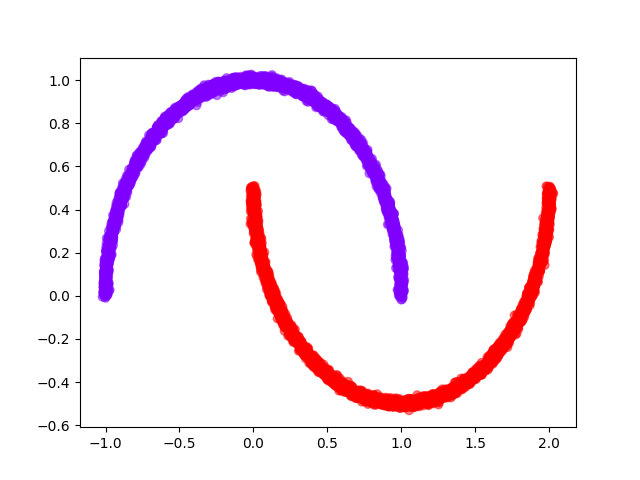

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as datasets
import torch
from torch.utils.data import DataLoader, Dataset, random_split

# we save images to outputs/ and read them instead of displaying them directly,
# this helps fix a matplotlib bug when doing live colla
os.makedirs("outputs", exist_ok=True)


class MoonsDataset(Dataset):
    def __init__(self, n_samples=10000, noise=0.01):
        X, y = datasets.make_moons(n_samples=10000, noise=noise)
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray)

        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


ds = MoonsDataset()
n_train, n_val, n_test = 6000, 2000, 2000
train_ds, val_ds, test_ds = random_split(ds, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

plt.scatter(ds.X[:, 0], ds.X[:, 1], c=ds.y, cmap="rainbow", alpha=0.5)
plt.savefig("outputs/moons.png")
plt.close()
Image.open("outputs/moons.png").show()


100%|██████████| 1000/1000 [07:18<00:00,  2.28it/s]


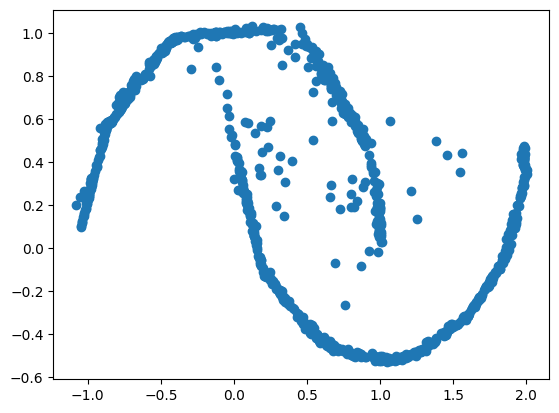

In [36]:
import torch.nn as nn
import torch.distributions
import torch.optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

class GAN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, z_dim: int) -> None:
        super().__init__()

        self.p_z = torch.distributions.Normal(loc=torch.zeros(z_dim), scale=torch.ones(z_dim))
        self.generator = nn.Sequential(
            nn.Linear(in_features=z_dim, out_features=hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_dim, out_features=input_dim)
        )

        self.discriminator = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_dim, out_features=1), 
            nn.Sigmoid()
        )

    def forward(self, n_samples: int) -> torch.Tensor:
        z = self.p_z.sample((n_samples, ))
        return self.generator(z)

    def disc_loss(self, x: torch.Tensor) -> torch.Tensor:
        z = self.p_z.sample((x.shape[0],))
        return -(torch.mean(torch.log(self.discriminator(x))) + torch.mean(torch.log(1 - self.discriminator(self.generator(z)))))


    def gen_loss(self, x: torch.Tensor) -> torch.Tensor:
        z = self.p_z.sample((x.shape[0],))
        return  torch.mean(torch.log(1 - self.discriminator(self.generator(z))))


model = GAN(2, 16, 8)
disc_opt = torch.optim.Adam(model.discriminator.parameters(), lr=1e-3)
gen_opt = torch.optim.Adam(model.generator.parameters(), lr=1e-3)

num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    for x, y in train_loader:
        disc_opt.zero_grad()
        gen_opt.zero_grad()
        gen_loss = model.gen_loss(x)
        gen_loss.backward()
        gen_opt.step()


        disc_opt.zero_grad()
        gen_opt.zero_grad()
        disc_loss = model.disc_loss(x)
        disc_loss.backward()
        disc_opt.step()



x_hat = model.forward(1000).detach().numpy()
plt.scatter(x_hat[:, 0], x_hat[:, 1])
plt.show()